## Импорт библиотек и просмотр заголовков  и содержимого набора данных 

Cтолбец numb.obs является индексным, поэтому определяем его соответветствующим в pandas.DataFrame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Загрузка и просмотр данных
df = pd.read_csv('beverage_r.csv', delimiter=';', index_col='numb.obs')
df.head()

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP
numb.obs,,,,,,,,
1,1,0,0,0,1,1,0,1
2,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0
5,1,0,0,0,1,0,0,0


## Оценка содержимого данных

In [2]:
beverage_counts = df.sum()

# Расчет процентного соотношения для каждого напитка
total_observations = len(df)
beverage_percentages = (beverage_counts / total_observations) * 100

# Объединение количества и процентов в одну таблицу
beverage_analysis_df = pd.DataFrame({
    'Beverage': beverage_counts.index,
    'Count': beverage_counts.values,
    'Percentage': beverage_percentages.values
})

# Сортировка данных по процентам и сброс индексов для аккуратного представления
beverage_analysis_df.sort_values(by='Percentage', ascending=False, inplace=True)
#beverage_analysis_df.index = beverage_analysis_df['Beverage']
#beverage_analysis_df.drop(columns=['Beverage'], inplace=True)
beverage_analysis_df.index = [''] * len(beverage_analysis_df)
# Вывод результатов
display(beverage_analysis_df)

,Beverage,Count,Percentage
,COKE,20,58.823529
,D_COKE,17,50.000000
,PEPSI,16,47.058824
,SPRITE,11,32.352941
,TAB,11,32.352941
,SEVENUP,9,26.470588
,D_PEPSI,8,23.529412
,D_7UP,7,20.588235


Coca-Cola (COKE) является самым популярным напитком, присутствуя в 58.8% всех наблюдений, за ним следует Diet Coke (D_COKE) с 50% и Pepsi (PEPSI) с 47.1%. 

# Кластеризация методом иерархического кластерного анализа

In [3]:
from scipy.cluster.hierarchy import linkage

# Применение иерархической кластеризации
link = linkage(df, method='ward', metric='euclidean')

# Просмотр содержимого объекта link
link_df = pd.DataFrame(link, columns=['Cluster_1', 'Cluster_2', 'Distance', 'Cluster_Size'])

# Отображение нескольких строк из конца матрицы link для анализа
link_df.iloc[22:]

,Cluster_1,Cluster_2,Distance,Cluster_Size
22,8.0,49.0,1.732051,3.0
23,47.0,52.0,1.825742,6.0
24,16.0,51.0,1.914854,4.0
25,42.0,48.0,1.936492,8.0
26,55.0,56.0,2.121320,7.0
27,58.0,60.0,2.276361,11.0
28,53.0,59.0,2.337118,11.0
29,54.0,57.0,2.379203,11.0
30,12.0,61.0,2.446395,12.0
31,62.0,64.0,3.876469,23.0


Тут столбцы:
- `Cluster_1` и `Cluster_2` - объединяемые кластеры (их номера)
- `Distance` - расстояние между объединяемыми кластерами
- `Cluster_Size` - размер итгового кластера (число объектов в нём)

## Вывод дендрограммы

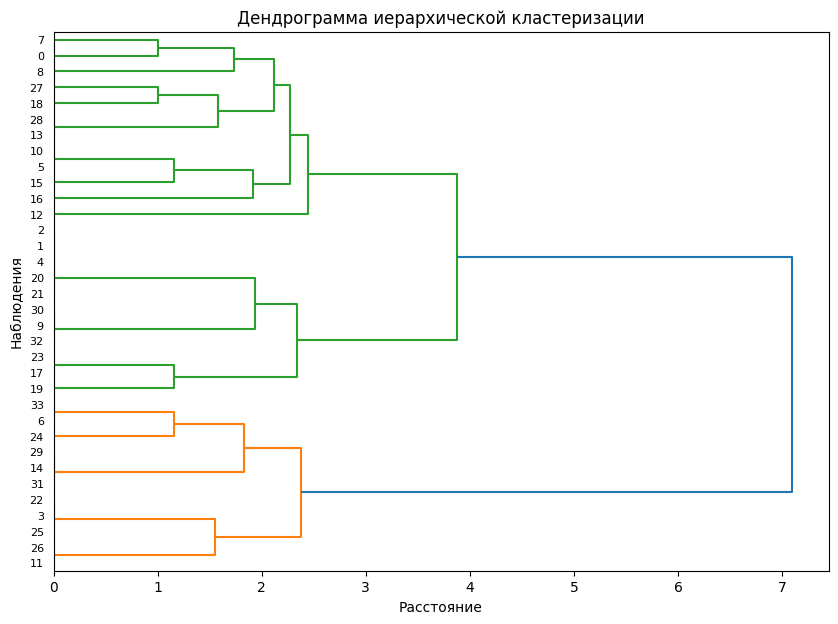

In [4]:
plt.figure(figsize=(10, 7))
dendrogram(link, orientation='right')
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Расстояние')
plt.ylabel('Наблюдения')
plt.show()


На дендрограмме каждое соединение между линиями представляет собой слияние кластеров. Высота соединения указывает на расстояние или различие между сливающимися кластерами.

Эта дендрограмма помогает визуально оценить, как данные группируются в кластеры, и может быть полезна для определения подходящего числа кластеров.
  
<b>Из дендрограммы видно, что наиболее логичным кажется разделить выборку на `3` кластера, по уровню расстояния 3 на дендрограмме</b>

## Выберем разделение на 3 кластера. Для каждого кластера найдем среднее арифтическое всех показателей и количество элементов в кластере

In [5]:
from scipy.cluster.hierarchy import fcluster

# Определение числа кластеров на основе дендрограммы (можно настроить)
# Здесь мы выбираем 3 кластера
number_of_clusters = 3

# Присваивание каждому наблюдению номера кластера
clusters = fcluster(link, number_of_clusters, criterion='maxclust')
df['cluster'] = clusters

# Группировка данных по кластерам и вычисление среднего
group = df.groupby('cluster')
cluster_means = group.mean()
cluster_means['size of a cluster'] = group.size()
cluster_means.round(3)

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP,size of a cluster
cluster,,,,,,,,,
1,0.00,1.000,0.545,0.545,0.000,0.000,0.909,0.000,11
2,1.00,0.273,0.091,0.000,1.000,0.000,0.000,0.273,11
3,0.75,0.250,0.083,0.083,0.417,0.917,0.083,0.500,12


Тут числа в яческах означают отношение сколько продукта попало в кластер к общему количеству объектов в кластере.

В последнем столбце - количество объектов в кластере

## Выводы

Иерархическая кластеризация с использованием метода Уорда и евклидова расстояния разделила предпочитающих напитки на 3 группы:
1) Группа "диабетиков"
    - Доминируют `D_COKE` и `TAB`.  
    - `D_PEPSI` и `D_7UP` - на среднем уровне.  
    - `COKE`, `PEPSI`, `SPRITE`, `SEVENUP`  - не встречаются.
2) Группа "любителей колы"
    - Доминируют `COKE` и `PEPSI`.
    - Редко встречаются `D_COKE`, `SEVENUP` и `D_PEPSI`.
    - Не встречаются `D_7UP`, `SPRITE`, `TAB`.
3) Группа "любителей вкуса лимона и лайма"
    - Доминируют `SPRITE` и `COKE`.
    - На среднем уровне - `SEVENUP` и `PEPSI`.
    - Редко - `D_COKE`.
    - Крайне редко - `D_PEPSI`, `D_7UP, TAB`.
    
Кластеры равномеро разделены: 11, 11, 12 наблюдений.

В группах 1 и 2 - ясно, что преобладают соответствующие названию напитки, а для группы 3 необходимо пояснение: я назвал группу любителями вкуса лимона и лайма, хотя там также встречаются и колы и диетические напитки.  
Содержание в кластере 3 колы (`COKE` и `PEPSI`) можно объяснить тем, что это очень популярные напитки (встречаются в `59%` и `47%` наблюдений соответственно).  
Содержание в кластерах 2 и 3 различных видов диетических напитков можно объяснить тем, что в выборках есть люди также следящие за своим весом.

# Кластеризация методом K-средних

In [6]:
#очищение данных от итогов предыдущей кластеризации
if 'cluster' in df.columns:
    df.drop(columns=['cluster'], inplace=True)
if 'is same' in df.columns:
    df.drop(columns=['is same'], inplace=True)
    df.drop(columns=['cluster Hr'], inplace=True)   
    df.drop(columns=['cluster Km'], inplace=True)   

from sklearn.cluster import KMeans
from collections import Counter

# Инициализация модели KMeans
model = KMeans(n_clusters=3, n_init=10, random_state=42)

# Подгонка модели по данным, исключая столбцы 'numb.obs' и 'cluster'
model.fit(df)

cluster_centers_df = pd.DataFrame(model.cluster_centers_, 
             columns=df.columns).round(3)
cluster_centers_df['size of a cluster'] = pd.Series(Counter(model.labels_))
cluster_centers_df.index = pd.Index(['0 - лайм','1 - диабет','2 - кола'], name='cluster number')
cluster_centers_df

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP,size of a cluster
cluster number,,,,,,,,,
0 - лайм,0.727,0.273,0.091,0.091,0.455,1.0,0.091,0.455,11
1 - диабет,0.000,1.000,0.545,0.545,-0.000,-0.0,0.909,0.000,11
2 - кола,1.000,0.250,0.083,0.000,0.917,-0.0,-0.000,0.333,12


Разобьем данные на 3 кластера, как и в методе иерархической кластеризации.  

Выведем на экран центры кластеров, подпишем столбцы и станет очевидно, что это почти та же самая таблица, что и таблица средних арифметических каждого кластера в предыдущем методе.  

Подпишем кластеры так, как мы их обозначили в выводе предыдущего метода.
В методе наименьших иерархий в кластере любителей лайма было 12 наблюдений, а тут - в кластере любителей колы.
Если посмотреть на дендрограмму, то как раз видно, что одно из наблюдений (номер 13) сильно выбивается из кластеров и присоединяется к одному из них довольно поздно.

## Определение наблюдения, кластера которого не совпали

In [7]:
# необходимо учесть, что кластеры имеют разные номера, но мы их интерпретируем как одинаковые:
# номера соответствуют следующим образом 
# (НОМЕРА КЛАСТЕРОВ МОГУТ ИЗМЕНИТЬСЯ ПОСЛЕ ПЕРЕЗАПУСКА/изменения random_state):
# 0 - 3
# 1 - 1
# 2 - 2
# т.е. необходимо заменить номер индекса 0 на 3:
model.labels_[model.labels_ == 0] = 3

# обозначим в одной таблице с данными кластера от обоих методов
df['cluster Hr'] = clusters # метод иерархий
df['cluster Km'] = model.labels_ # метод К-средних

df['is same'] = (df['cluster Km'] - df['cluster Hr']) == 0
display(df[df['is same'] != True])

df.drop(columns=['is same'], inplace=True)
df.drop(columns=['cluster Hr'], inplace=True)   
df.drop(columns=['cluster Km'], inplace=True)   

,COKE,D_COKE,D_PEPSI,D_7UP,PEPSI,SPRITE,TAB,SEVENUP,cluster Hr,cluster Km,is same
numb.obs,,,,,,,,,,,
19,1,0,0,0,0,0,0,1,3,2,False


Данное наблюдение содержит как COKE, так и SEVENUP, соответственно может быть отнесено как в группу любителей колы (метод К-средних), так и в группу любителей лайма (метод иерархий). 

## Определение расстояний между наблюдениями

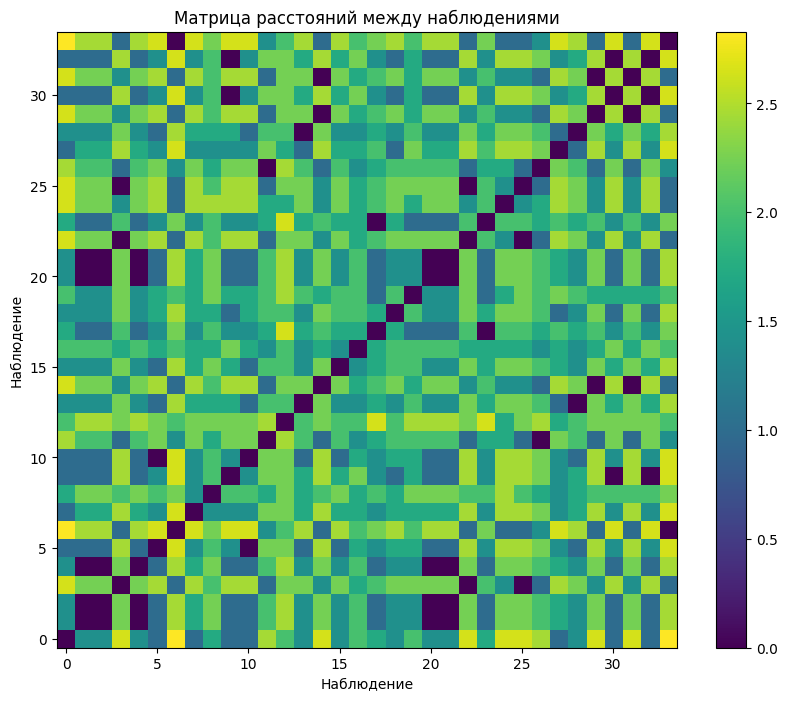

In [8]:
from scipy.spatial.distance import pdist, squareform

# Вычисление матрицы расстояний
distances = pdist(df, metric='euclidean')
distance_matrix = squareform(distances)

# Создание графика расстояний
plt.figure(figsize=(10, 8))
plt.imshow(distance_matrix, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Матрица расстояний между наблюдениями')
plt.xlabel('Наблюдение')
plt.ylabel('Наблюдение')
plt.show()

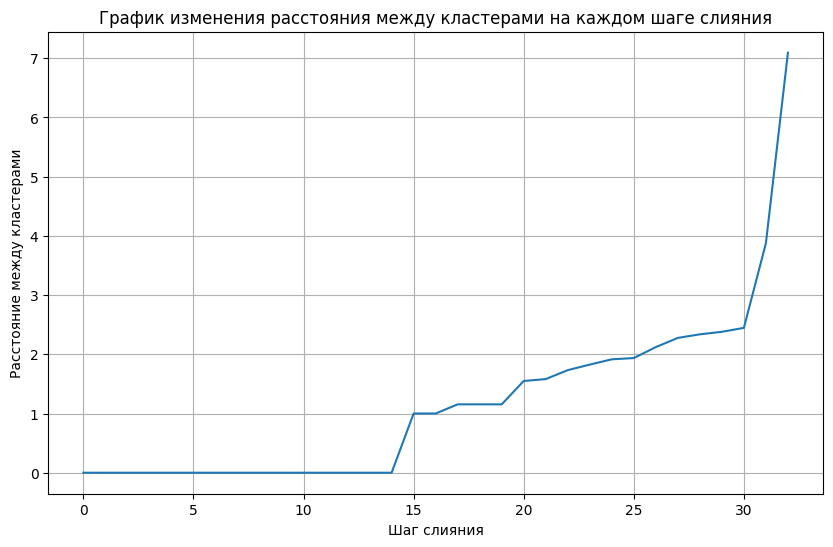

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(link[:, 2])
plt.title('График изменения расстояния между кластерами на каждом шаге слияния')
plt.xlabel('Шаг слияния')
plt.ylabel('Расстояние между кластерами')
plt.grid(True)
plt.show()

## Графики центров кластеров

#### Изобразили одномерные графики центров кластеров, для каждого напитка, соединенные пунктиром в рамках одного кластера

0 1


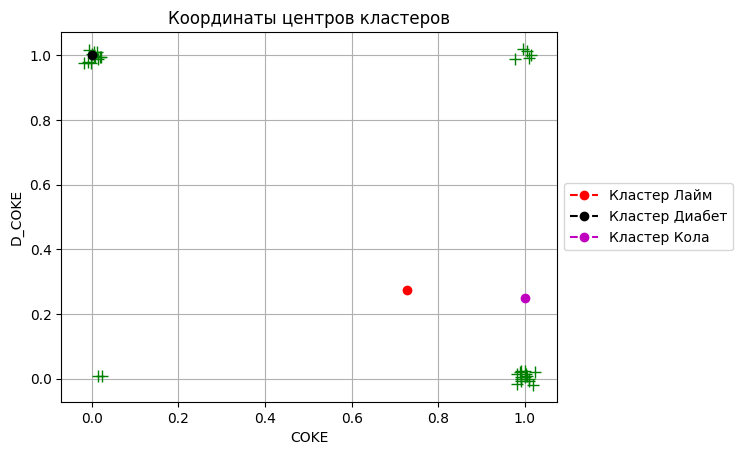

0 2


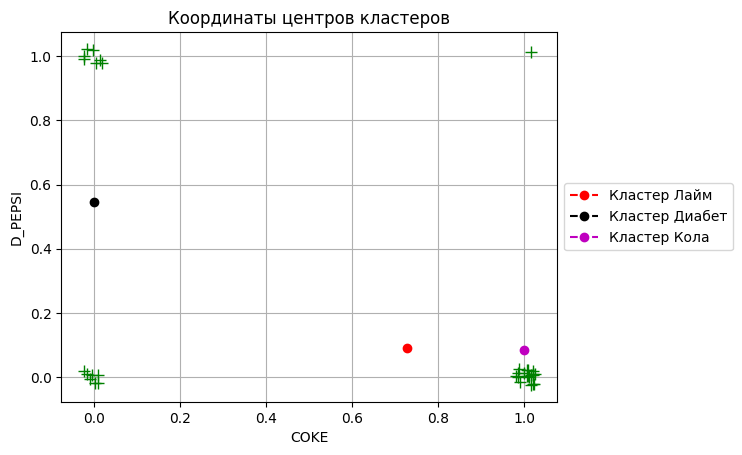

0 3


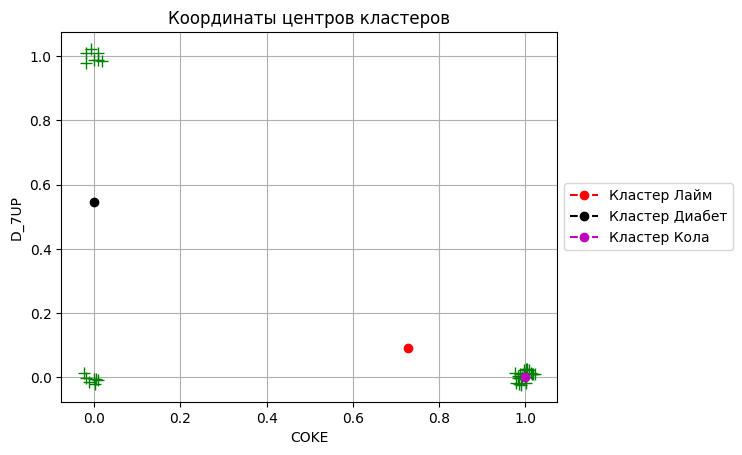

0 4


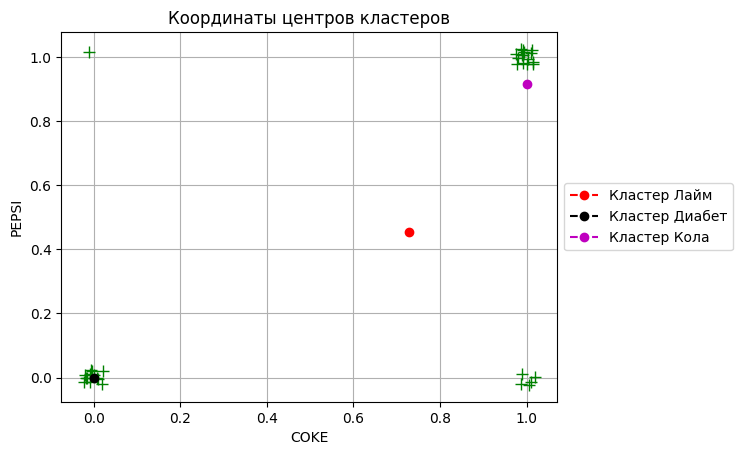

0 5


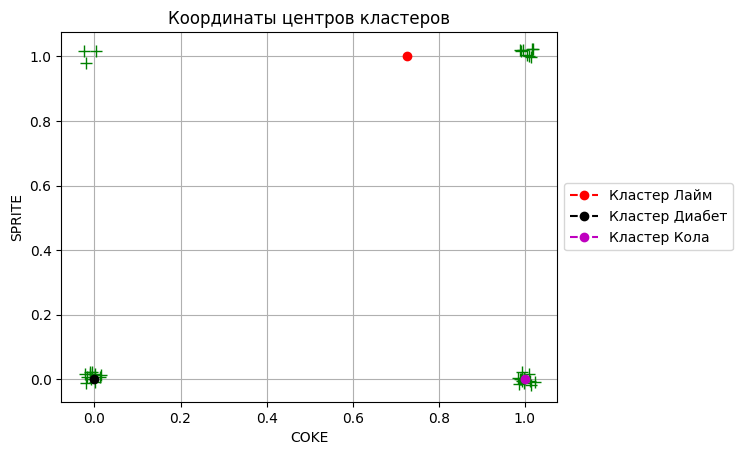

0 6


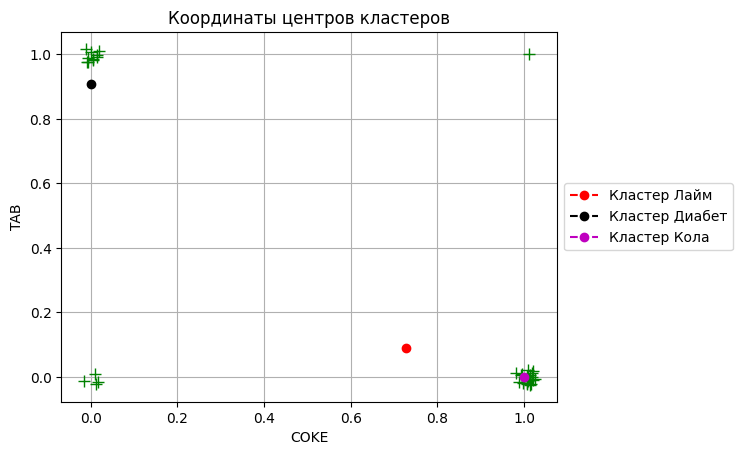

0 7


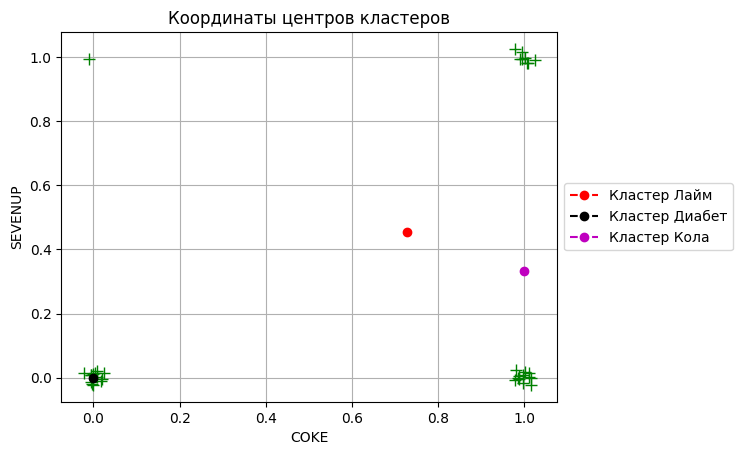

1 2


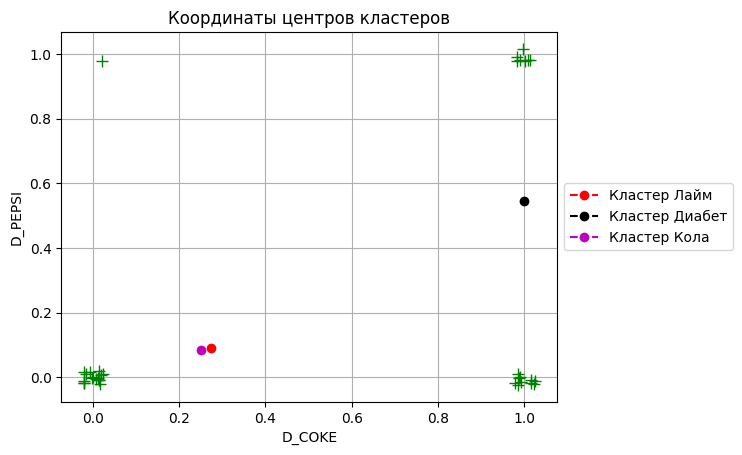

1 3


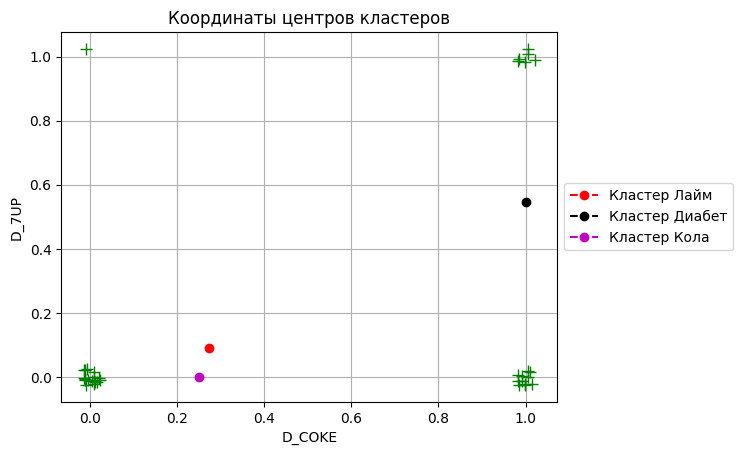

1 4


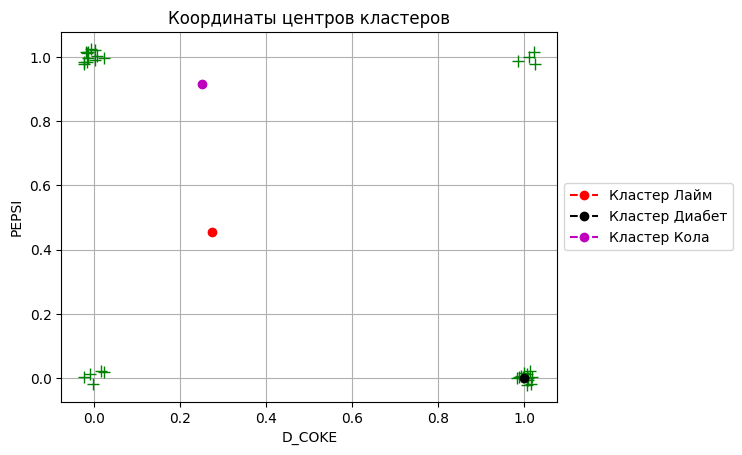

1 5


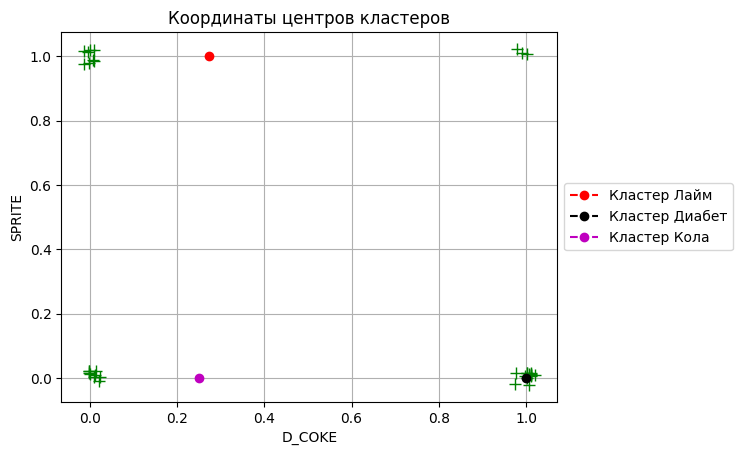

1 6


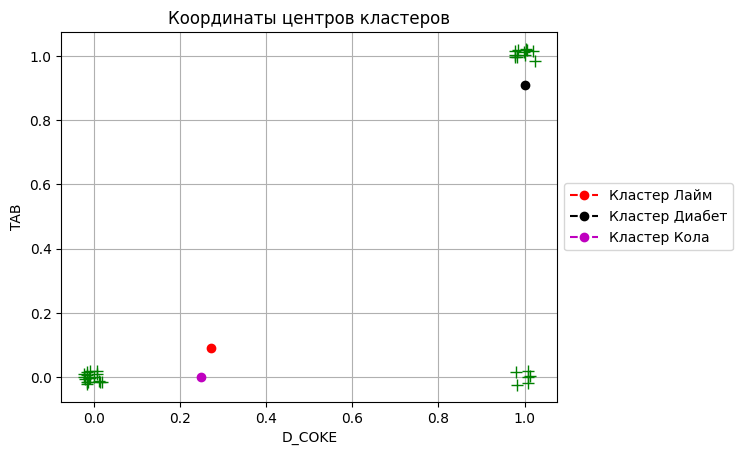

1 7


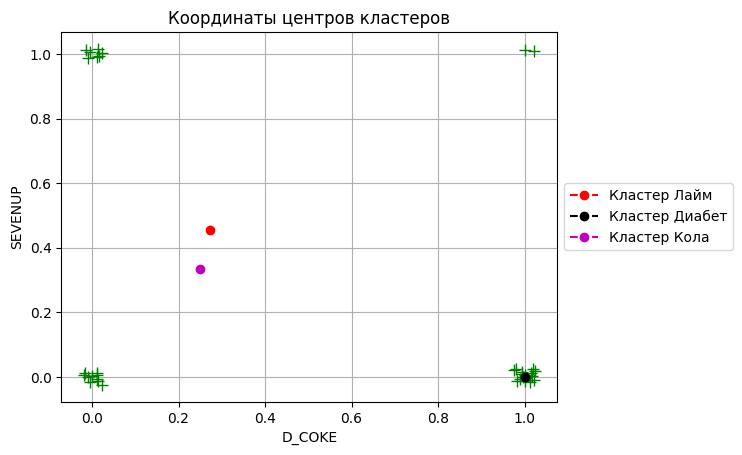

2 3


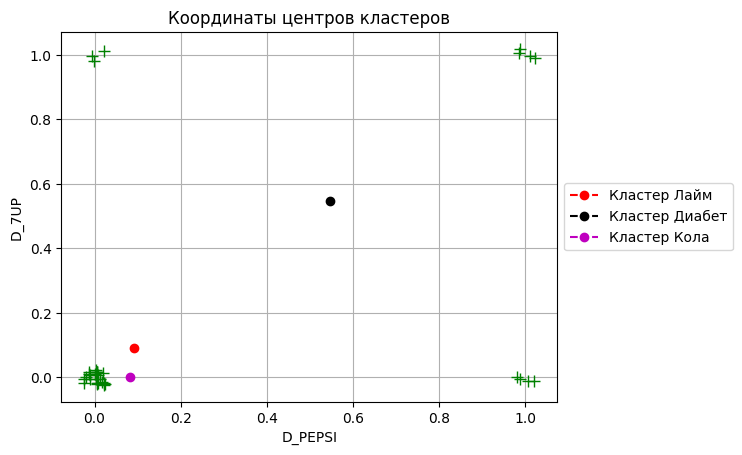

2 4


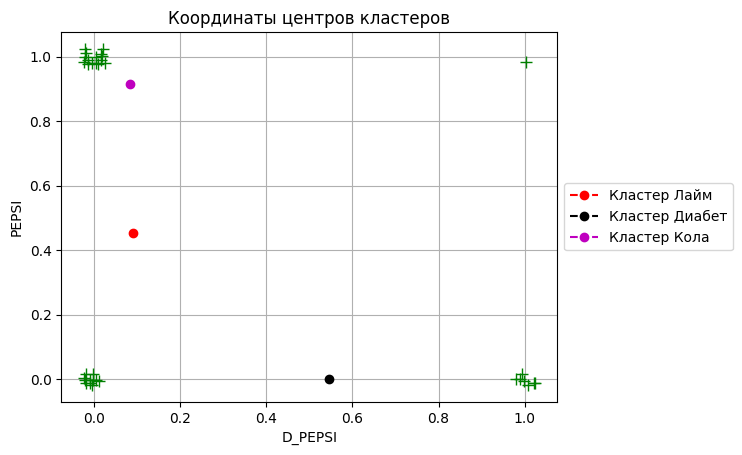

2 5


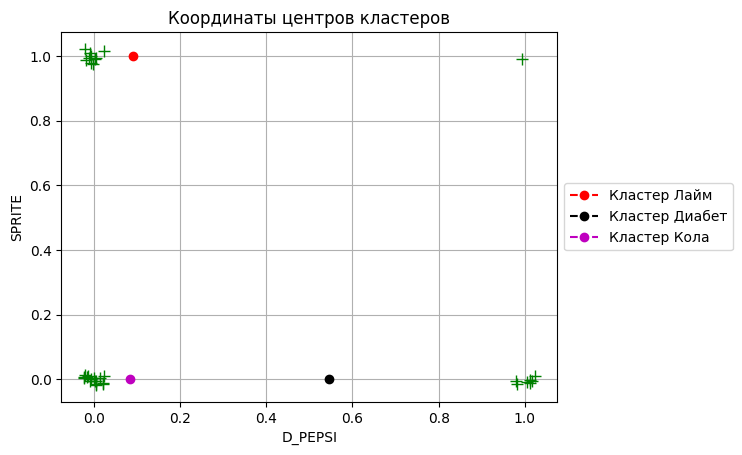

2 6


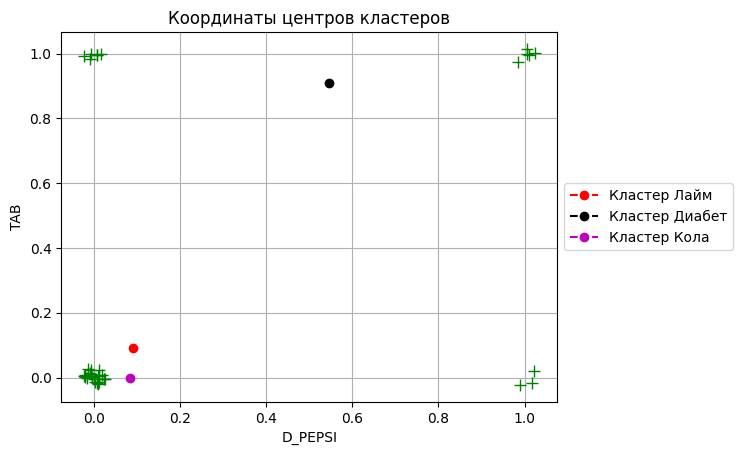

2 7


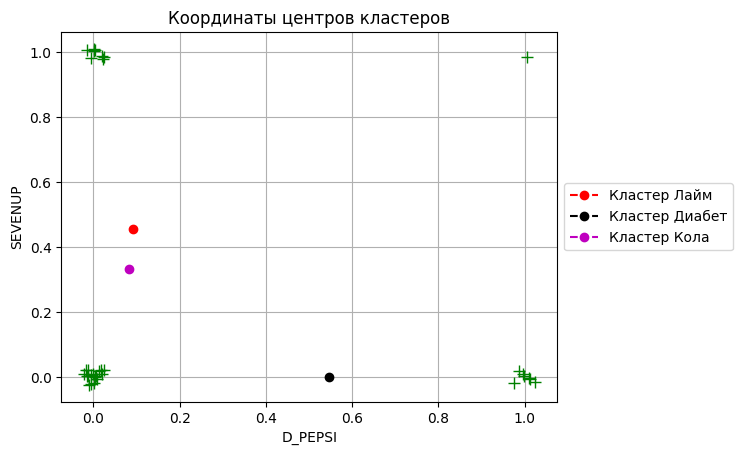

3 4


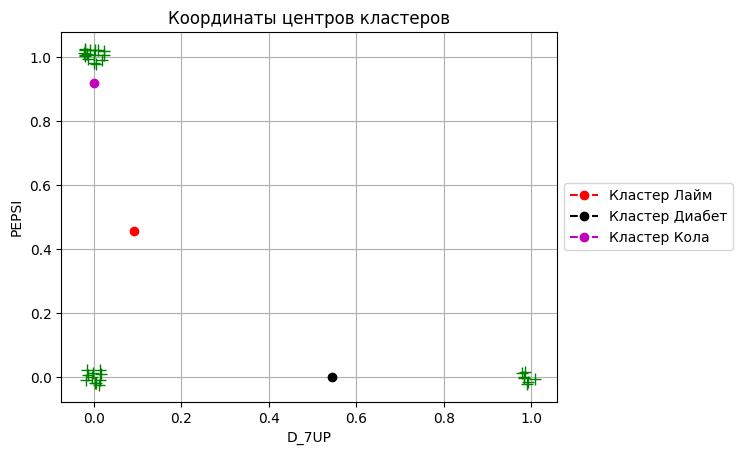

3 5


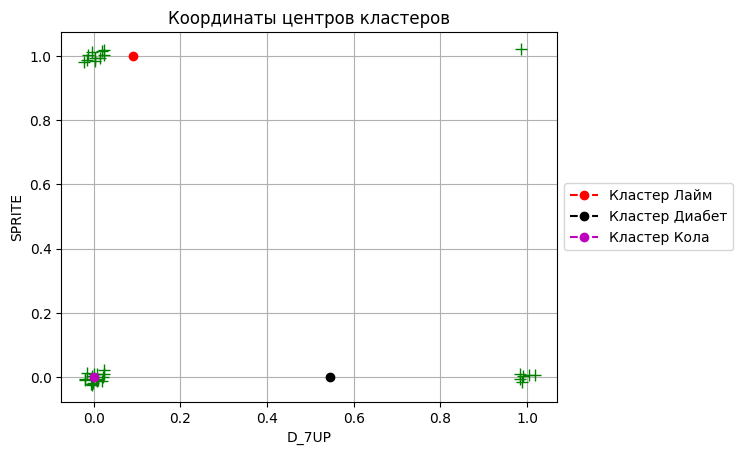

3 6


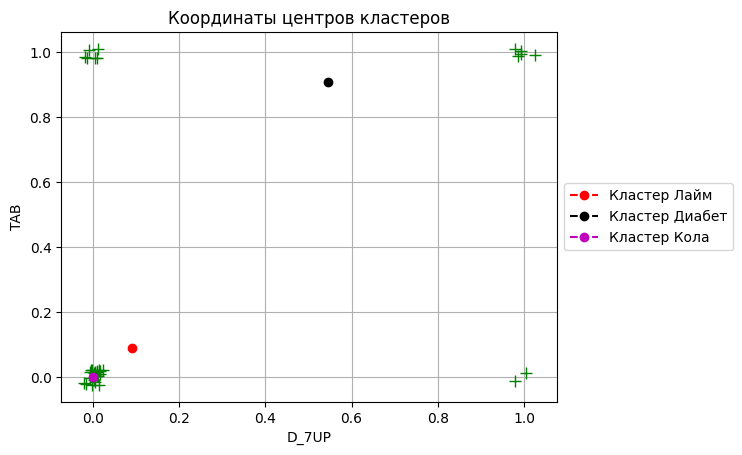

3 7


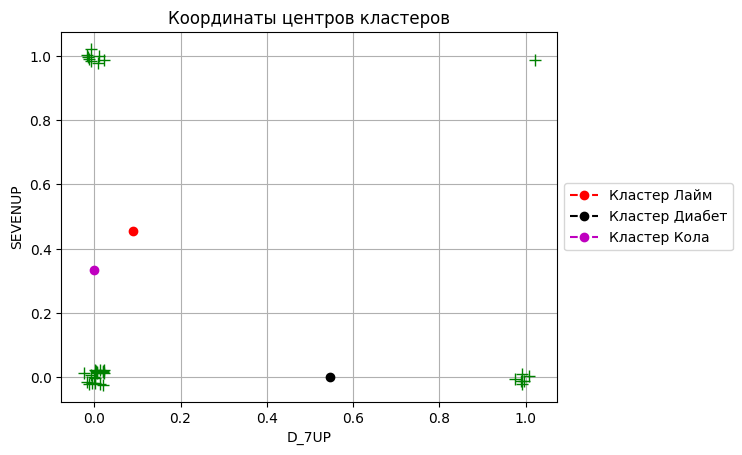

4 5


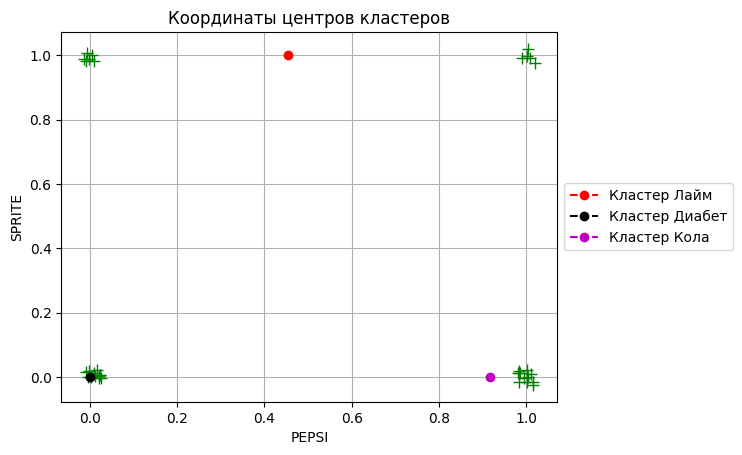

4 6


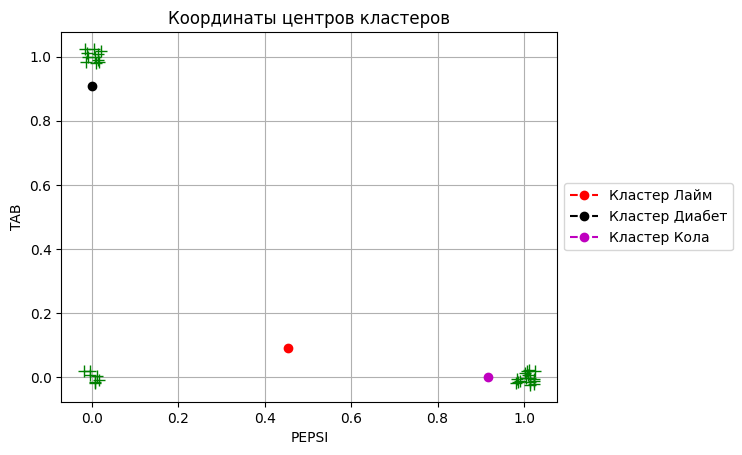

4 7


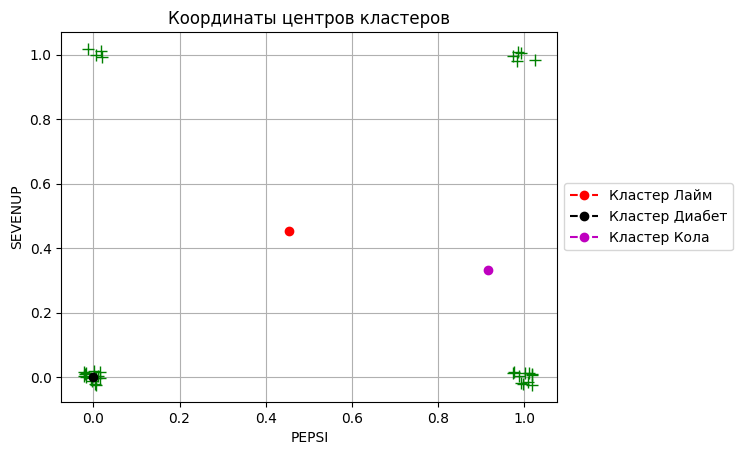

5 6


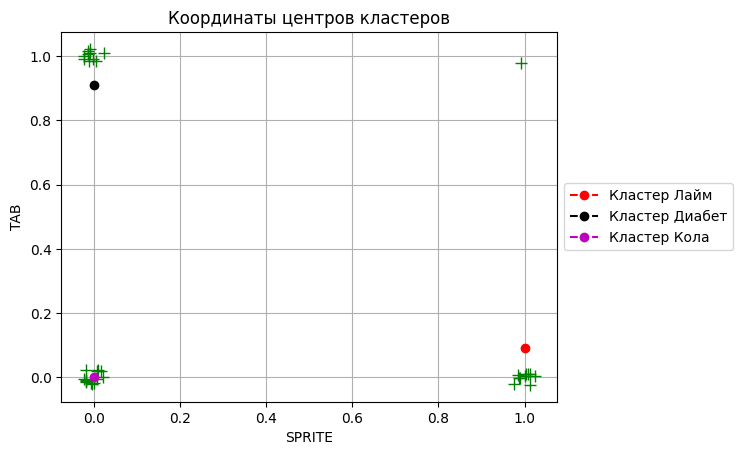

5 7


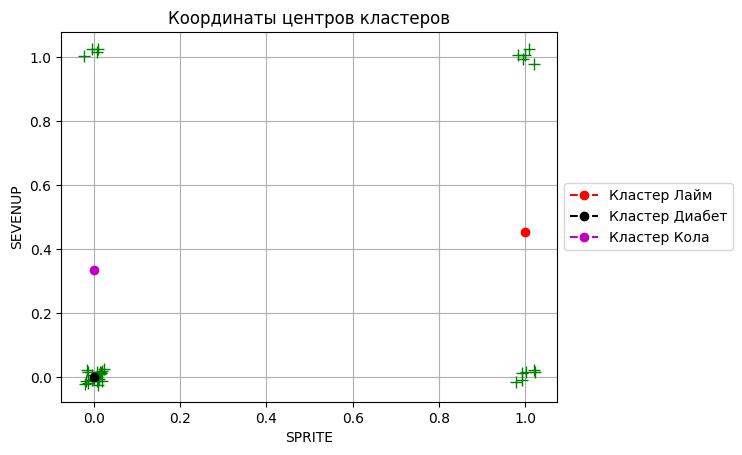

6 7


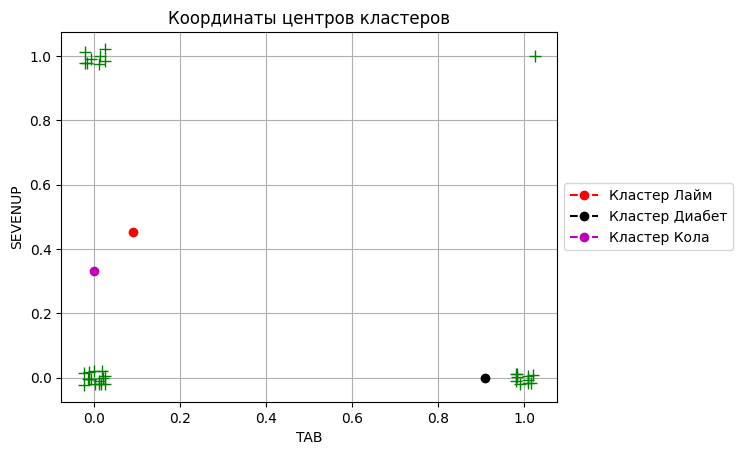

In [50]:
import numpy as np
import matplotlib.gridspec as gridspec

# Количество напитков (столбцы, за исключением 'numb.obs' и 'cluster')
num_beverages = len(df.columns)

# Диапазон для оси x (один столбец для каждого напитка)
x = np.arange(num_beverages)
cl0 = model.cluster_centers_[0]
cl1 = model.cluster_centers_[1]
cl2 = model.cluster_centers_[2]

x, y = (0,0)
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(5, 5)
while x < len(df.columns) - 1:
    y += 1
    ax = fig.add_subplot(gs[x, y])
    # Построение координат для каждого кластера
    ax.plot(df.iloc(axis=1)[x] + (np.random.rand(len(df))-0.5)*0.05, 
             df.iloc(axis=1)[y] + (np.random.rand(len(df))-0.5)*0.05, 'g+',
            markersize=8)
    ax.plot(cl0[x], cl0[y], 'r--.', label='Кластер Лайм', markersize=12)
    ax.plot(cl1[x], cl1[y], 'k--.', label='Кластер Диабет', markersize=12)
    ax.plot(cl2[x], cl2[y], 'm--.', label='Кластер Кола', markersize=12)

    # Добавление меток и легенды
    plt.title('Координаты центров кластеров')
    ax.xlabel(df.iloc(axis=1)[x].name)
    ax.ylabel(df.iloc(axis=1)[y].name)
    lt.legend(loc='center left', bbox_to_anchor=(1, .5))
    plt.grid(True)
    plt.show()
    
    if not (y < len(df.columns) - 1):
        x += 1
        y = x